In [1]:
!pip install torch==1.9.0
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 27.0 MB/s 
  Attempting uninstall: torchtext
    Found existing instal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install numpy
!pip install pandas
!pip install nltk
!pip install transformers
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 23.8 MB/s 
     |████████████████████████████████| 163 kB 52.1 MB/s 
     |████████████████████████████████| 7.6 MB 52.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=eb8c97ee6f62c66cb8ef049a2ef0124f33ef70478998869e288a817c57187c5a
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [ ]:
!nvidia-smi

Fri Oct 28 14:38:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import numpy as np
import pandas as pd
import nltk
import torch
from transformers import BertTokenizer
from torchtext.legacy import data
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertModel
import torch.nn as nn
import torch.optim as optim
import math
import time
import matplotlib.pyplot as plt

#from transformers import *


In [ ]:
train_df = pd.read_feather('/content/drive/MyDrive/duplicate/train_dataset.feather')
test_df = pd.read_feather('/content/drive/MyDrive/duplicate/test_dataset.feather')
val_df = pd.read_feather('/content/drive/MyDrive/duplicate/validation_dataset.feather')

In [ ]:
def trim_sentence(sent):
    try:
        sent = sent.split()
        sent = sent[:128]
        return " ".join(sent)
    except:
        return sent

train_df['q1_trimmed'] = train_df['q1_cleaned'].apply(lambda x: trim_sentence(x))
train_df['q2_trimmed'] = train_df['q2_cleaned'].apply(lambda x: trim_sentence(x))

val_df['q1_trimmed'] = val_df['q1_cleaned'].apply(lambda x: trim_sentence(x))
val_df['q2_trimmed'] = val_df['q2_cleaned'].apply(lambda x: trim_sentence(x))

test_df['q1_trimmed'] = test_df['q1_cleaned'].apply(lambda x: trim_sentence(x))
test_df['q2_trimmed'] = test_df['q2_cleaned'].apply(lambda x: trim_sentence(x))

In [ ]:
# def common_words(row):
#     w1 = set(map(lambda word: word.lower().strip(), row['q1_cleaned'].split(" ")))
#     w2 = set(map(lambda word: word.lower().strip(), row['q2_cleaned'].split(" ")))    
#     return len(w1 & w2)
    
# df['jaccard_dist'] = nltk.jaccard_distance(set(df['q1_cleaned']), set(df['q2_cleaned']))
# df['common_words'] = df.apply(common_words, axis=1)
# df['common_ratio'] = df.apply(lambda row: row['common_words'] / (len(row['q1_cleaned']) + len(row['q2_cleaned'])), axis=1)

In [10]:
# Masking the tokens to feed into BERT
def sent1_token_type(sentence):
    try:
        return [0]* len(sentence)
    except:
        return []
    
#Get list of 1s
def sent2_token_type(sentence):
    try:
        return [1]* len(sentence)
    except:
        return []

#combine from lists
def combine_seq(seq):
    return " ".join(seq)

#combines from lists of int
def combine_mask(mask):
    mask = list(map(str, mask))
    return " ".join(mask)

#convert attention mask back to list of int
def convert_mask(tok_ids):
    tok_ids = [int(x) for x in tok_ids]
    return tok_ids

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
cls_token = tokenizer.cls_token
sep_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
cls_token_idx = tokenizer.cls_token_id
sep_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_bert(sentence):
    tokens = tokenizer.tokenize(sentence) 
    return tokens


def split_and_cut(sentence):
    tokens = sentence.strip().split(" ")
    tokens = tokens[:max_input_length] # make sure that it does not overflow
    return tokens

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
# [SEP]: A special token separating two different sentences in the same input (used by BERT for instance)
# [CLS]: A special token representing the class of the input (used by BERT for instance)
# They do not contribute to sentence length and will be ignored by attention mask
train_df['q1_padded'] = '[CLS] ' + train_df['q1_trimmed'] + ' [SEP] '
train_df['q2_padded'] = train_df['q2_trimmed'] + ' [SEP]'

train_df['q1_bert_tokens'] = train_df['q1_padded'].apply(lambda x: tokenize_bert(x))
train_df['q2_bert_tokens'] = train_df['q2_padded'].apply(lambda x: tokenize_bert(x))

val_df['q1_padded'] = '[CLS] ' + val_df['q1_trimmed'] + ' [SEP] '
val_df['q2_padded'] = val_df['q2_trimmed'] + ' [SEP]'

val_df['q1_bert_tokens'] = val_df['q1_padded'].apply(lambda x: tokenize_bert(x))
val_df['q2_bert_tokens'] = val_df['q2_padded'].apply(lambda x: tokenize_bert(x))

test_df['q1_padded'] = '[CLS] ' + test_df['q1_trimmed'] + ' [SEP] '
test_df['q2_padded'] = test_df['q2_trimmed'] + ' [SEP]'

test_df['q1_bert_tokens'] = test_df['q1_padded'].apply(lambda x: tokenize_bert(x))
test_df['q2_bert_tokens'] = test_df['q2_padded'].apply(lambda x: tokenize_bert(x))

In [ ]:
train_df['q1_token_type'] = train_df['q1_bert_tokens'].apply(lambda x: sent1_token_type(x))
train_df['q2_token_type'] = train_df['q2_bert_tokens'].apply(lambda x: sent2_token_type(x))

val_df['q1_token_type'] = val_df['q1_bert_tokens'].apply(lambda x: sent1_token_type(x))
val_df['q2_token_type'] = val_df['q2_bert_tokens'].apply(lambda x: sent2_token_type(x))

test_df['q1_token_type'] = test_df['q1_bert_tokens'].apply(lambda x: sent1_token_type(x))
test_df['q2_token_type'] = test_df['q2_bert_tokens'].apply(lambda x: sent2_token_type(x))

In [ ]:
train_df['sequence'] = train_df['q1_bert_tokens'] + train_df['q2_bert_tokens']
train_df['attn_mask'] = train_df['sequence'].apply(lambda x: sent2_token_type(x)) # every word needs attention
train_df['token_type'] = train_df['q1_token_type'] + train_df['q2_token_type']

val_df['sequence'] = val_df['q1_bert_tokens'] + val_df['q2_bert_tokens']
val_df['attn_mask'] = val_df['sequence'].apply(lambda x: sent2_token_type(x)) # every word needs attention
val_df['token_type'] = val_df['q1_token_type'] + val_df['q2_token_type']

test_df['sequence'] = test_df['q1_bert_tokens'] + test_df['q2_bert_tokens']
test_df['attn_mask'] = test_df['sequence'].apply(lambda x: sent2_token_type(x)) # every word needs attention
test_df['token_type'] = test_df['q1_token_type'] + test_df['q2_token_type']

In [ ]:
# Make all the inputs to be sequential in string instead of list
train_df['sequence'] = train_df['sequence'].apply(lambda x: combine_seq(x))
train_df['attn_mask'] = train_df['attn_mask'].apply(lambda x: combine_mask(x))
train_df['token_type'] = train_df['token_type'].apply(lambda x: combine_mask(x))

val_df['sequence'] = val_df['sequence'].apply(lambda x: combine_seq(x))
val_df['attn_mask'] = val_df['attn_mask'].apply(lambda x: combine_mask(x))
val_df['token_type'] = val_df['token_type'].apply(lambda x: combine_mask(x))

test_df['sequence'] = test_df['sequence'].apply(lambda x: combine_seq(x))
test_df['attn_mask'] = test_df['attn_mask'].apply(lambda x: combine_mask(x))
test_df['token_type'] = test_df['token_type'].apply(lambda x: combine_mask(x))

In [12]:
#For sequence
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = split_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)
#For label
LABEL = data.LabelField()

#For Attention mask
ATTENTION = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = split_and_cut,
                  preprocessing = convert_mask,
                  pad_token = pad_token_idx)
#For token type ids
TTYPE = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = split_and_cut,
                  preprocessing = convert_mask,
                  pad_token = 1)

In [ ]:
train_df = train_df[['sequence', 'attn_mask', 'token_type', 'is_duplicate']]
val_df = val_df[['sequence', 'attn_mask', 'token_type', 'is_duplicate']]
test_df = test_df[['sequence', 'attn_mask', 'token_type', 'is_duplicate']]

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/duplicate/bert_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/duplicate/bert_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/duplicate/bert_test.csv')

In [ ]:
# train_df = train_df.sample(frac=0.3)
# val_df = val_df.sample(frac=0.3)
# test_df = test_df.sample(frac=0.3)

In [ ]:
# train_df.to_csv('/content/drive/MyDrive/duplicate/bert_train.csv', index = False)
# val_df.to_csv('/content/drive/MyDrive/duplicate/bert_val.csv', index = False)
# test_df.to_csv('/content/drive/MyDrive/duplicate/bert_test.csv', index = False)

In [14]:
fields = [('sequence', TEXT), ('attn_mask', ATTENTION), ('token_type', TTYPE), ('is_duplicate', LABEL)]

train_data, valid_data, test_data = data.TabularDataset.splits(path = '/content/drive/MyDrive/duplicate/',
                                                    train = 'bert_train.csv',
                                                    validation = 'bert_val.csv',
                                                    test = 'bert_test.csv',
                                                    format = 'csv',
                                                    fields = fields,
                                                    skip_header = True)
#Create iterator
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
print(len(train_data), len(valid_data), len(test_data))

323429 40429 40429


In [ ]:
# Create Python class object of the datasets with predefined batch size (following pytorch format)
train_iterator, valid_iterator, test_iterator= data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                            batch_size = BATCH_SIZE,
                                                            sort_key = lambda x: len(x.sequence),
                                                            sort_within_batch = False, 
                                                            device = device)

In [16]:
LABEL.build_vocab(train_data)
print(len(LABEL.vocab))

2


In [8]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
class BERTNLIModel(nn.Module):
    def __init__(self, bert_model, output_dim):
        super().__init__()
        self.bert = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.out = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, sequence, attn_mask, token_type):
        embedded = self.bert(input_ids=sequence, attention_mask=attn_mask, token_type_ids=token_type)[1]
        output = self.out(embedded)
        return output

OUTPUT_DIM = len(LABEL.vocab)
model = BERTNLIModel(bert_model, OUTPUT_DIM).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/duplicate/bert_model_full.pt'))#, map_location=device))

<All keys matched successfully>

In [18]:
optimizer = transformers.AdamW(model.parameters(),lr=2e-5,eps=1e-6,correct_bias=False) # AdamW algorithm as optimizer
criterion = nn.CrossEntropyLoss().to(device) # cross-entropy loss as loss function

def get_scheduler(optimizer, warmup_steps):
    """
    Create a schedule with a constant learning rate preceded by a warmup period during 
    which the learning rate increases linearly between 0 and the initial lr set in the optimizer.

    Pytorch learning rate scheduler is used to find the optimal learning rate for various models by conisdering the model architecture and parameters
    """
    scheduler = transformers.get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)
    return scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True) # just keep the max argument

    correct = (max_preds.squeeze(1)==y).float() # removed all the dimensions of input of size 1

    return correct.sum() / len(y)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion, scheduler):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad() # clear gradients first
        torch.cuda.empty_cache() # releases all unoccupied cached memory
        
        sequence = batch.sequence
        attn_mask = batch.attn_mask
        token_type = batch.token_type
        label = batch.is_duplicate
        
        predictions = model(sequence, attn_mask, token_type)
        loss = criterion(predictions, label)
        acc = categorical_accuracy(predictions, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            sequence = batch.sequence

            attn_mask = batch.attn_mask
            token_type = batch.token_type
            labels = batch.is_duplicate

            predictions = model(sequence, attn_mask, token_type)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 7
warmup_percent = 0.2
total_steps = math.ceil(N_EPOCHS*len(train_data)*1./BATCH_SIZE)
warmup_steps = int(total_steps*warmup_percent)
scheduler = get_scheduler(optimizer, warmup_steps)
best_valid_loss = float('inf')
train_loss_list = []
train_acc_list= []
valid_loss_list = []
valid_acc_list= []

for epoch in range(N_EPOCHS):
    print('################################# Epoch ' + str(epoch + 1) + ' #################################')
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),  '/content/drive/MyDrive/duplicate/bert_model_full.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

################################# Epoch 1 #################################
Epoch: 01 | Epoch Time: 64m 21s
Train Loss: 0.102 | Train Acc: 96.21%
Val. Loss: 0.278 | Val. Acc: 90.19%
################################# Epoch 2 #################################
Epoch: 02 | Epoch Time: 64m 15s
Train Loss: 0.107 | Train Acc: 96.00%
Val. Loss: 0.289 | Val. Acc: 90.47%
################################# Epoch 3 #################################
Epoch: 03 | Epoch Time: 64m 19s
Train Loss: 0.085 | Train Acc: 96.87%
Val. Loss: 0.302 | Val. Acc: 90.27%
################################# Epoch 4 #################################


Since Google Colab penalised free users for hogging resources, so the training process is broken down into 2 separate times due to "idle time" exceeded. We overcome this problem by saving the Pytorch model if the validation loss decreases after every epoch. The attached images below show the 7 epoch we had run in 2 separate occasions: 

1st run: 
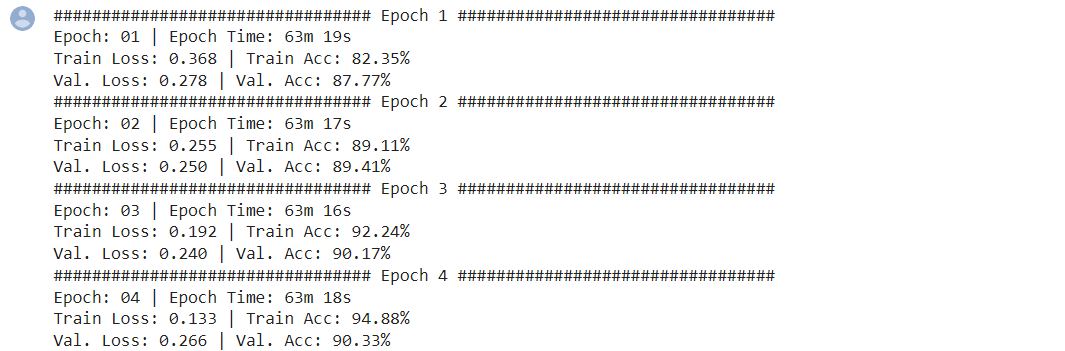

2nd run:  

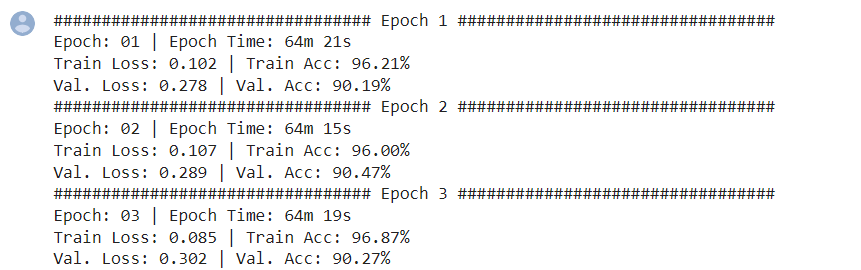

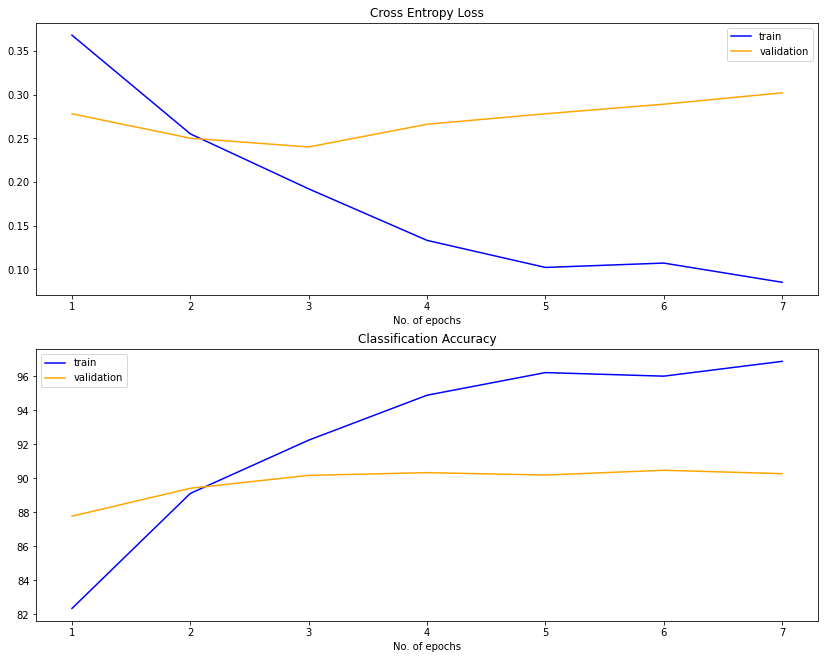

In [ ]:
train_loss_list = [0.368, 0.255, 0.192, 0.133, 0.102, 0.107, 0.085]
val_loss_list = [0.278, 0.250, 0.240, 0.266, 0.278, 0.289, 0.302]
train_acc_list = [82.35, 89.11, 92.24, 94.88, 96.21, 96.00, 96.87]
val_acc_list = [87.77, 89.41, 90.17, 90.33, 90.19, 90.47, 90.27]

plt.figure(figsize=(14,11))
plt.subplot(2, 1, 1)
plt.title('Cross Entropy Loss')
plt.xlabel('No. of epochs')
plt.plot(range(1, 8), train_loss_list, color='blue', label='train')
plt.plot(range(1, 8), val_loss_list, color='orange', label='validation')
plt.legend()
# plot accuracy
plt.subplot(2, 1, 2)
plt.title('Classification Accuracy')
plt.xlabel('No. of epochs')
plt.plot(range(1, 8), train_acc_list, color='blue', label='train')
plt.plot(range(1, 8), val_acc_list, color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/duplicate/bert_model_full.pt'))
valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print('Validation loss: ', valid_loss, ', Validation accuracy: ', valid_acc)

Validation loss:  0.23950932770485953 , Validation accuracy:  0.9016506346875045


In [ ]:
print('Test loss: ', test_loss, ', Test accuracy: ', test_acc)

Test loss:  0.24006917195465904 , Test accuracy:  0.900697467352592


In [20]:
def predict_inference(q1, q2, model, device):
    model.eval()
    
    q1 = '[CLS] ' + str(q1) + ' [SEP]'
    q2 = str(q2) + ' [SEP]'
    
    q1_t = tokenize_bert(q1)
    q2_t = tokenize_bert(q2)
    
    q1_type = sent1_token_type(q1_t)
    q2_type = sent2_token_type(q2_t)
    
    indexes = q1_t + q2_t
    indexes = tokenizer.convert_tokens_to_ids(indexes)
    
    indexes_type = q1_type + q2_type
    
    attn_mask = sent2_token_type(indexes)
    
    # indexes = torch.IntTensor(indexes).unsqueeze(0).to(device)
    # indexes_type = torch.IntTensor(indexes_type).unsqueeze(0).to(device)
    # attn_mask = torch.IntTensor(attn_mask).unsqueeze(0).to(device)
    indexes = TEXT.numericalize(indexes, device=device).unsqueeze(0)
    indexes_type = TTYPE.numericalize(indexes_type, device=device).unsqueeze(0)
    attn_mask = ATTENTION.numericalize(attn_mask, device=device).unsqueeze(0)
    
    prediction = model(indexes, attn_mask, indexes_type)
    prediction = prediction.argmax(dim=-1).item()
    return prediction

def predict_prob_inference(q1, q2, model, device):
    model.eval()
    
    q1 = '[CLS] ' + str(q1) + ' [SEP]'
    q2 = str(q2) + ' [SEP]'
    
    q1_t = tokenize_bert(q1)
    q2_t = tokenize_bert(q2)
    
    q1_type = sent1_token_type(q1_t)
    q2_type = sent2_token_type(q2_t)
    
    indexes = q1_t + q2_t
    indexes = tokenizer.convert_tokens_to_ids(indexes)
    
    indexes_type = q1_type + q2_type
    
    attn_mask = sent2_token_type(indexes)
    
    # indexes = torch.IntTensor(indexes).unsqueeze(0).to(device)
    # indexes_type = torch.IntTensor(indexes_type).unsqueeze(0).to(device)
    # attn_mask = torch.IntTensor(attn_mask).unsqueeze(0).to(device)
    indexes = TEXT.numericalize(indexes, device=device).unsqueeze(0)
    indexes_type = TTYPE.numericalize(indexes_type, device=device).unsqueeze(0)
    attn_mask = ATTENTION.numericalize(attn_mask, device=device).unsqueeze(0)
    
    prediction = model(indexes, attn_mask, indexes_type)
    prob = prediction.max(dim=-1)
    return prob[0][0].item()

In [5]:
train_f = pd.read_feather('/content/drive/MyDrive/duplicate/train_dataset.feather')
val_f = pd.read_feather('/content/drive/MyDrive/duplicate/validation_dataset.feather')
test_f = pd.read_feather('/content/drive/MyDrive/duplicate/test_dataset.feather')

In [ ]:
# print('doing on train')
# train_f['bert_pred'] = train_f.apply(lambda x: predict_inference(x['q1_trimmed'], x['q2_trimmed'], model, device), axis=1)
# print('doing on val')
# val_f['bert_pred'] = val_f.apply(lambda x: predict_inference(x['q1_trimmed'], x['q2_trimmed'], model, device), axis=1)

# print('doing on test')
# test_f['bert_pred'] = test_f.apply(lambda x: predict_inference(x['q1_trimmed'], x['q2_trimmed'], model, device), axis=1)

In [ ]:
# train_f.to_feather('/content/drive/MyDrive/duplicate/train_dataset.feather')

In [ ]:
# predict_prob_inference('Is living in this world worth?', 'Is surviving in this Earth worth?', model, device)

0.8442699909210205


torch.return_types.max(
values=tensor([0.8443], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

In [21]:
print('doing on train')
train_f['bert_maxval'] = train_f.apply(lambda x: predict_prob_inference(x['q1_trimmed'], x['q2_trimmed'], model, device), axis=1)
print('doing on val')
val_f['bert_maxval'] = val_f.apply(lambda x: predict_prob_inference(x['q1_trimmed'], x['q2_trimmed'], model, device), axis=1)
print('doing on test')
test_f['bert_maxval'] = test_f.apply(lambda x: predict_prob_inference(x['q1_trimmed'], x['q2_trimmed'], model, device), axis=1)

doing on train
doing on val
doing on test


In [23]:
train_f.to_feather('/content/drive/MyDrive/duplicate/train_dataset.feather')
val_f.to_feather('/content/drive/MyDrive/duplicate/validation_dataset.feather')
test_f.to_feather('/content/drive/MyDrive/duplicate/test_dataset.feather')